# Explicación del caso

El objetivo de este laboratorio es crear un modelo que pueda predecir la cantidad total de precipitación que llega al suelo en determinado período se expresa en términos de profundidad vertical de agua que cubriría una proyección horizontal de la superficie de la Tierra, se expresa en milímetros (mm). Con el propósito principal para el uso de planificación de riego en la agricultura.

###Librerías a usar

In [274]:
# Importación de librerías
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.linear_model import LinearRegression   # para modelos de regresion lineal
from sklearn.linear_model import Ridge   # Ridge regression
from sklearn.linear_model import Lasso   # Lasso regression
from sklearn.linear_model import ElasticNet  # ElasticNet regression
from sklearn.neighbors import KNeighborsRegressor  # Knn regression
from sklearn.tree import DecisionTreeRegressor   # Decision Trees regression

from sklearn.model_selection import train_test_split  # para partir los datos en conjuntos de entrenamiento y validacion
from sklearn.model_selection import KFold  # para partir la data en k-folds
from sklearn.model_selection import cross_val_score   # para evaluar algoritmos en cross validacion

from sklearn.metrics import mean_squared_error, mean_absolute_error   # para manejar metricas de desempeño
from sklearn.metrics import explained_variance_score  # para hacer reportes de resultados de clasificacion
from sklearn.metrics import r2_score  # para manejar matrices de confusion

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import RobustScaler

from sklearn.pipeline import make_pipeline

from sklearn.decomposition import PCA

warnings.filterwarnings("ignore")

###Descripción de las variables del Data frame base

VARIABLE | DESCRIPCIÓN | TIPO  
---------|-------------|-----  
**FECHA_CORTE** | Fecha de corte de información | Numérico  
**UBIGEO** | Código de Ubicación Geográfica que denotan "DDppdd" (Departamento, provincia, distrito) | Alfanumérico  
**YY** | Year, año de registro | Numérico  
**MM** | Month, mes de registro | Numérico  
**DY** | Day, día de registro | Numérico  
**HH** | Hour, hora promedio del registro | Numérico  
**TT** | Air Temperature 2 meters (temperatura del aire a 2 metros) - [°C] | Numérico  
**HR** | Relative Humidity (Humedad Relativa) - [%] | Numérico  
**RR** | Precipitation (precipitación) - [mm] | Numérico  
**PP** | Atmospheric pressure (presión atmosférica) - [hPa] | Numérico  
**FF** | Wind speed (velocidad del aire) - [m/s] | Numérico  
**DD** | Wind direction (dirección del aire) - [grados] | Numérico  


In [275]:
# Lectura del dataset base
df_base = pd.read_csv('IGP_EstacionEMA_2018-2024_Dataset.csv')
# se elimina las columnas FECHA_CORTE y UBIGEO porque son constantes
df_base.drop(columns=["FECHA_CORTE","UBIGEO"],inplace=True)
df_base.head()

,YY,MM,DY,HH,TT,HR,RR,PP,FF,DD
0,2018,1,1,0,7.66098,89.51500,1.778,687.40333,2.97943,145.64165
1,2018,1,1,1,7.73552,90.29500,0.254,686.94167,1.70000,284.01833
2,2018,1,1,2,7.57108,91.00500,0.254,686.67667,1.65667,63.06462
3,2018,1,1,3,7.52045,89.73167,0.000,686.50000,1.13227,34.77467
4,2018,1,1,4,7.13343,88.88167,0.508,686.60333,0.64763,72.41817


###Descripción de las variables del Data frame auxiliar que tiene diferentes niveles de temperatura, humedad, datos del viento y flujo de calor

VARIABLE | DESCRIPCIÓN | TIPO  
---------|-------------|-----  
**FECHA_CORTE** | Fecha de corte de información | Numérico  
**UBIGEO** | Código de Ubicación Geográfica que denotan "DDppdd" (Departamento, provincia, distrito) | Alfanumérico  
**year** | Year, año de registro | Numérico  
**month** | Month, mes de registro | Numérico  
**day** | Day, día de registro | Numérico  
**hour** | Hour, hora promedio del registro | Numérico  
**temp_n1** | Temperatura del aire (2 m) - [°C] | Numérico  
**temp_n2** | Temperatura del aire (6 m) - [°C] | Numérico  
**temp_n3** | Temperatura del aire (12 m) - [°C] | Numérico  
**temp_n4** | Temperatura del aire (18 m) - [°C] | Numérico  
**temp_n5** | Temperatura del aire (24 m) - [°C] | Numérico  
**temp_n6** | Temperatura del aire (29 m) - [°C] | Numérico  
**wind_n1** | Velocidad del viento (2 m) - [m/s] | Numérico  
**wind_n2** | Velocidad del viento (6 m) - [m/s] | Numérico  
**wind_n3** | Velocidad del viento (12 m) - [m/s] | Numérico  
**wind_n4** | Velocidad del viento (18 m) - [m/s] | Numérico  
**wind_n5** | Velocidad del viento (24 m) - [m/s] | Numérico  
**wind_n6** | Velocidad del viento (29 m) - [m/s] | Numérico  
**RH_n1** | Humedad relativa (2 m) - [%] | Numérico  
**RH_n2** | Humedad relativa (6 m) - [%] | Numérico  
**RH_n3** | Humedad relativa (12 m) - [%] | Numérico  
**RH_n4** | Humedad relativa (18 m) - [%] | Numérico  
**RH_n5** | Humedad relativa (24 m) - [%] | Numérico  
**RH_n6** | Humedad relativa (29 m) - [%] | Numérico  
**dir_wind_01** | Dirección del viento (18 m) - [grados] | Numérico  
**dir_wind_02** | Dirección del viento (29 m) - [grados] | Numérico  
**soil_heat** | Flujo de calor del suelo (8 cm) - [W/m²] | Numérico  

In [276]:
# Lectura del dataset auxiliar de diferentes temperaturas, vientos y humedades a diferentes niveles
# además de tener flujo de calor
df_aux1 = pd.read_csv('IGP_EstacionTorreGradiente_2018-2025_Dataset_0.csv')
# se elimina las columnas FECHA_CORTE y UBIGEO porque son constantes
df_aux1.drop(columns=["FECHA_CORTE","UBIGEO"],inplace=True)
df_aux1.head()

,year,month,day,hour,temp_n1,temp_n2,temp_n3,temp_n4,temp_n5,temp_n6,...,RH_n6,wind_n1,wind_n2,wind_n3,wind_n4,wind_n5,wind_n6,dir_wind_01,dir_wind_02,soil_heat
0,2018,5,15,14,20.07117,19.61817,19.34850,19.46133,19.08433,19.33050,...,24.84250,1.27615,1.51282,1.63960,1.71803,1.74843,1.73988,137.73583,130.83133,-59.62925
1,2018,5,15,15,20.02767,19.67267,19.47667,19.56783,19.16500,19.43300,...,23.91850,1.49800,1.81533,2.00695,2.13998,2.31407,2.38310,121.96283,125.40717,-48.84940
2,2018,5,15,16,17.48100,17.61083,17.65217,17.85100,17.56950,17.86733,...,34.13567,1.67402,2.57707,3.06792,3.31683,3.61100,3.69643,80.40917,82.49550,-29.88178
3,2018,5,15,17,14.95833,15.22533,15.36433,15.60517,15.34500,15.66717,...,45.07883,1.10408,1.98747,2.41770,2.64992,2.78088,2.93363,182.83367,178.57800,-10.57230
4,2018,5,15,18,12.82483,12.93933,13.02117,13.28333,13.05917,13.41967,...,55.58850,2.40263,3.54670,4.24970,4.78075,5.08188,5.33525,326.46833,325.56333,-0.51723


### Descripción de Variables del DataFrame auxiliar de diferentes irridancias de onda

VARIABLE | DESCRIPCIÓN | TIPO
---------|-------------|-----
**FECHA_CORTE**	| Fecha de corte de información |	Numérico
**UBIGEO**	| Código de Ubicación Geografica que denotan "DDppdd" (Departamento, provincia,distrito)| 	Alfanumérico
**year** |	Year, año de registro |	Numérico
**month** |	Month, mes de registro |	Numérico
**day** |	Day, dia de registro |	Numérico
**hour** | Hour, hora promedio del registro	| Numérico
**incide_LW_rad** |	Incident longwave irradiance (irradiancia incidente de onda larga) W m^{-2} |	Numérico
**emitte_LW_rad** | 	Emitted longwave irradiance (irradiancia emitida de onda larga) W m^{-2}	| Numérico
**direct_SW_rad** |	Direct shortwave irradiance (irradiancia directa de onda corta) W m^{-2}	| Numérico
**global_SW_rad** |	Global shortwave irrandiance (irradiancia glocal de onda corta) W m^{-2}	| Numérico
**diffus_SW_rad** |	Diffuse shortwave irradiance (irradiancia difusa de onda corta) W m^{-2}	| Numérico
**reflec_SW_rad** |	Reflected shortwave irradiance (irradiancia reflejada de onda corta) W m^{-2}	| Numérico

In [277]:
# Lectura del dataset auxiliar de diferentes irridancias de onda
# además de tener flujo de calor
df_aux2 = pd.read_csv('IGP_EstacionBSRN_2021-2023_Dataset_0.csv')
# se elimina las columnas FECHA_CORTE y UBIGEO porque son constantes
df_aux2.drop(columns=["FECHA_CORTE","UBIGEO"],inplace=True)
df_aux2.head()

,year,month,day,hour,incide_LW_rad,emitte_LW_rad,direct_SW_rad,global_SW_rad,diffus_SW_rad,reflec_SW_rad
0,2021,1,1,0,352.05167,367.13500,-0.25327,0.0,0.0,0.0
1,2021,1,1,1,352.87167,364.62333,-0.20893,0.0,0.0,0.0
2,2021,1,1,2,345.94833,359.72500,-0.22720,0.0,0.0,0.0
3,2021,1,1,3,343.00833,357.59000,-0.15992,0.0,0.0,0.0
4,2021,1,1,4,341.39167,357.58333,-0.11268,0.0,0.0,0.0


**Decisión 1:** Se procede a renombrar las columnas del dataframe base a los mismos nombres para las fechas que tienen los data frames auxiliares por 2 motivos:


1.   Las variables se van a poder entender por sí mismas sin usar el diccionario de datos
2.   Poder aplicar un merge sin problemas porque las columnas se llaman igual



In [278]:
# Renombramiento de las columnas para que coincidan con los otros data frames
df_base.rename(columns={'YY': 'year', 'MM': 'month', 'DY': 'day', 'HH': 'hour'}, inplace=True)

In [279]:
df_final = df_base.merge(df_aux1, on=['year', 'month', 'day', 'hour'], how='inner') \
              .merge(df_aux2, on=['year', 'month', 'day', 'hour'], how='inner')
print(df_final.shape)
df_final.head()

(22320, 37)


,year,month,day,hour,TT,HR,RR,PP,FF,DD,...,wind_n6,dir_wind_01,dir_wind_02,soil_heat,incide_LW_rad,emitte_LW_rad,direct_SW_rad,global_SW_rad,diffus_SW_rad,reflec_SW_rad
0,2021,2,12,0,9.95433,87.33167,0.0,685.24500,2.14650,310.51333,...,2.26142,307.46167,306.09333,24.12440,339.41333,364.94333,-0.01435,0.0,0.0,0.0
1,2021,2,12,1,9.55950,87.44333,0.0,684.69167,0.99983,266.69333,...,0.92000,268.80667,279.72500,23.33845,294.05500,355.35667,0.22748,0.0,0.0,0.0
2,2021,2,12,2,8.27083,90.56500,0.0,684.31667,2.18750,307.17000,...,2.25942,303.42333,305.51833,26.54748,293.22833,351.89500,0.28117,0.0,0.0,0.0
3,2021,2,12,3,8.33633,91.54333,0.0,684.18667,1.45300,283.64500,...,1.61452,271.86667,271.06500,27.09582,327.48000,357.63833,0.02092,0.0,0.0,0.0
4,2021,2,12,4,8.90883,87.14833,0.0,684.10000,1.32500,277.32667,...,1.23345,269.13333,265.04333,24.68715,317.46167,357.28500,0.02817,0.0,0.0,0.0


In [280]:
# Mostrar todas las columnas, el tipo de dato de cada columna y sus datos faltantes
resumen = pd.DataFrame({
    'columna': df_final.columns,
    'tipo_dato': df_final.dtypes.values,
    'nulos (%)': df_final.isnull().sum().values / len(df_final) * 100,
})

print(resumen)

          columna tipo_dato  nulos (%)
0            year     int64   0.000000
1           month     int64   0.000000
2             day     int64   0.000000
3            hour     int64   0.000000
4              TT   float64   0.035842
5              HR   float64   0.035842
6              RR   float64   0.035842
7              PP   float64   0.035842
8              FF   float64   0.035842
9              DD   float64   0.035842
10        temp_n1   float64   0.936380
11        temp_n2   float64   0.936380
12        temp_n3   float64   0.936380
13        temp_n4   float64   0.936380
14        temp_n5   float64   0.936380
15        temp_n6   float64   0.936380
16          RH_n1   float64   0.936380
17          RH_n2   float64   0.936380
18          RH_n3   float64   0.936380
19          RH_n4   float64   0.936380
20          RH_n5   float64   0.936380
21          RH_n6   float64   0.936380
22        wind_n1   float64   0.936380
23        wind_n2   float64   0.936380
24        wind_n3   float

**Decisión 2:** Se procede a borrar los nulos porque en el análisis anterior verificamos que la cantidad de nulos no es demasiada. Entonces se prefiere eliminarlos envés de imputar datos porque esto generaría un sesgo. Además de que la cantidad de datos que tenemos es bien grande, por lo que podemos eliminarlos.

In [281]:
# Borrado de nulos
df_final.dropna(inplace=True)
print(df_final.shape)

(14465, 37)


**Decisión 3:** Se proyectan las variables en PC1 y PC2 usando PCA para ver la variabilidad que provee cada variable en sus 2 proyecciones. Entonces borramos las 3 variables que proporcionan menos variabilidad.

              PC1       PC2
temp_n4  0.222929  0.075419
temp_n3  0.222637  0.084611
temp_n6  0.222271  0.066572
temp_n5  0.222221  0.068423
RH_n1    0.220125  0.008818
temp_n2  0.220048  0.102428
HR       0.219489  0.006256
temp_n1  0.217116  0.115802
TT       0.217018  0.116445
RH_n2    0.215166  0.008744


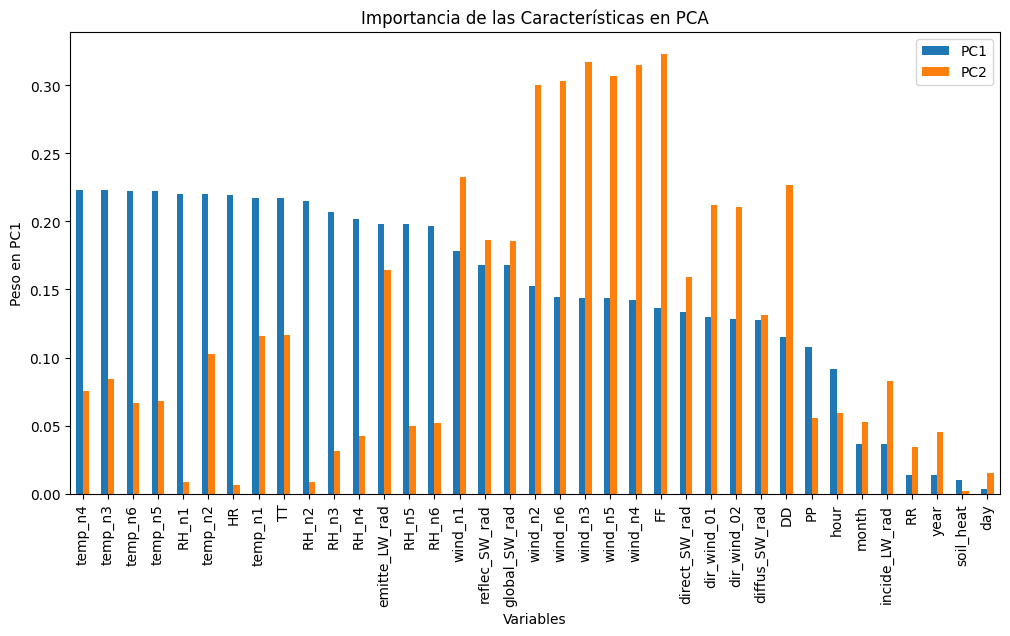

In [282]:
# Normalizar los datos (escalar todas las columnas)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_final)

# Aplicar PCA
pca = PCA(n_components=min(df_scaled.shape))  # Número máximo de componentes
pca.fit(df_scaled)

# Obtener la importancia de cada característica
importance = np.abs(pca.components_[:2])  # Tomamos las primeras 2 componentes principales

# Convertir en DataFrame para visualización
columns = df_final.columns
importance_df = pd.DataFrame(importance.T, index=columns, columns=['PC1', 'PC2'])

# Ordenar por relevancia en la primera componente principal
importance_df = importance_df.sort_values(by='PC1', ascending=False)

# Mostrar las variables más influyentes
print(importance_df.head(10))  # Muestra las 10 más relevantes

# Graficar la importancia de las características
importance_df.plot(kind='bar', figsize=(12, 6))
plt.title('Importancia de las Características en PCA')
plt.xlabel('Variables')
plt.ylabel('Peso en PC1')
plt.show()

**Decisión 4:** Se procede a generar una matriz de correlación para eliminar las columnas redundantes. En caso de redundancia, se decide quedarse con las variables más genéricas.

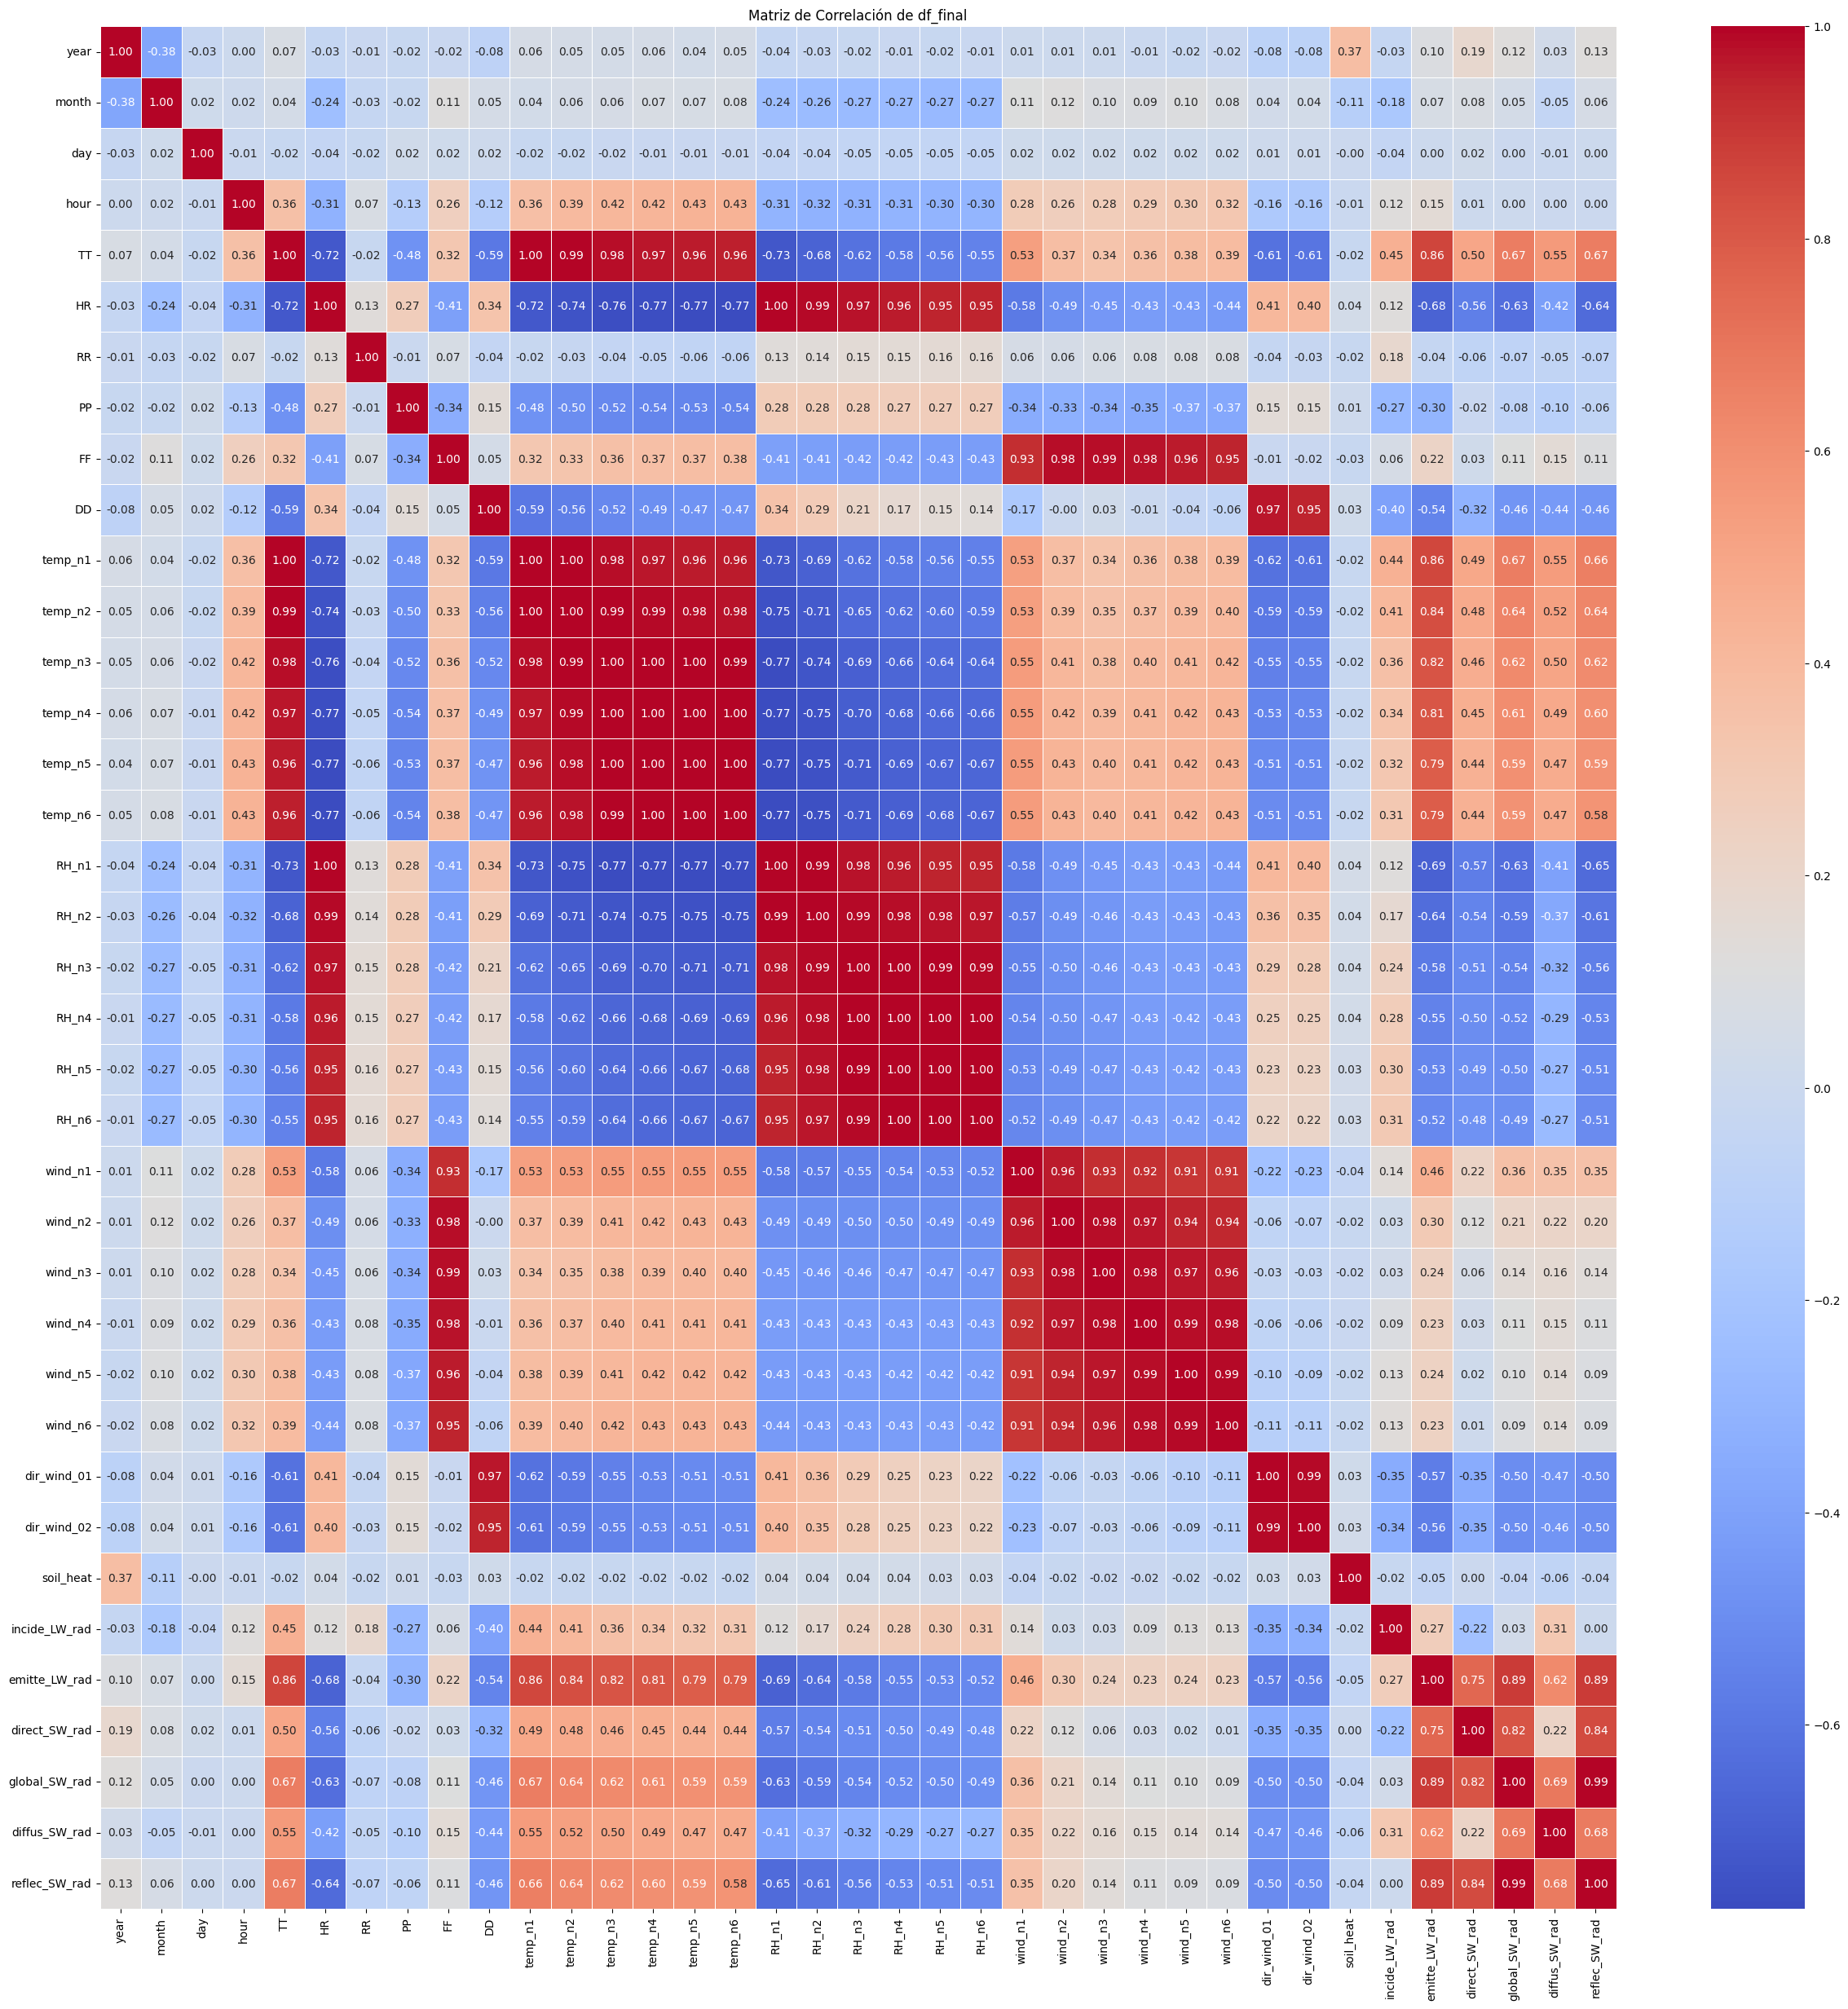

In [283]:
# Calcular la matriz de correlación del df_final
corr_matrix = df_final.corr()

# Graficar el mapa de calor con los valores numéricos
plt.figure(figsize=(30, 30))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)

# Guardar el gráfico como imagen
#plt.savefig("matriz_correlacion.png", dpi=300, bbox_inches="tight")

# Mostrar el gráfico
plt.title('Matriz de Correlación de df_final')
plt.show()

In [284]:
redundant_columns = ['temp_n1','temp_n2','temp_n3','temp_n4','temp_n5','temp_n6',
                     'RH_n1','RH_n2','RH_n3','RH_n4','RH_n5','RH_n6',
                     'wind_n1','wind_n2','wind_n3','wind_n4','wind_n5','wind_n6',
                     'dir_wind_01','dir_wind_02','reflec_SW_rad']
less_valuable_columns = ['day','soil_heat','year']
df_final.drop(columns=redundant_columns, inplace=True)
df_final.drop(columns=less_valuable_columns, inplace=True)
df_final.shape

(14465, 13)

##Se procede a entrenar el modelo de regresión lineal
Para el entrenamiento de este modelo solo se tienen en cuenta las filas donde la precipitación sea mayor que 0 por el propósito de ser usado después de haber pasado por un modelo de clasificación.

In [285]:
# Separación  del dataset en atributos (X)  y  target (y)
df_reg_lineal = df_final.copy()
df_cl = df_final.copy()
df_reg_lineal = df_reg_lineal[df_reg_lineal['RR'] > 0]
y = df_reg_lineal['RR']   #extrae la variable target
X = df_reg_lineal.drop(['RR'], axis=1)  # extrae las variables de entrada (sin target)

#Realizar la división de los datos en subconjuntos
test_size = 0.20    # proporcion de muestras para validacion
seed = 55   # semilla para el generador aleatorio (para reproductibilidad)
x_train,x_test,y_train,y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

# Impresión el tamaño del dataset de entrenamiento y de prueba
print("Tamaño del conjunto de entrenamiento:", len(y_train))
print("Tamaño del conjunto de prueba:", len(y_test))

Tamaño del conjunto de entrenamiento: 691
Tamaño del conjunto de prueba: 173


In [286]:
# Definimos el pool de algoritmos de ML a evaluar
algos = []

algos.append(('LinearReg', LinearRegression()))
algos.append(('Ridge', Ridge()))
algos.append(('Lasso', Lasso()))
algos.append(('ElasticNet', ElasticNet()))
algos.append(('KNN_5', KNeighborsRegressor(n_neighbors=5)))
algos.append(('KNN_10', KNeighborsRegressor(n_neighbors=10)))
algos.append(('RegTrees', DecisionTreeRegressor()))
algos.append(('RegTrees_10', DecisionTreeRegressor(max_depth=10)))

In [287]:
# Evaluamos cada algoritmo de ML en estrategia de 10-fold-CV
results = []
names = []

# genera el particionamiento de 10 folds que seran usados en cada evaluacion
seed = 42 # COMPLETAR
kfold = KFold(n_splits=10, random_state=seed, shuffle= True)  # especifica el particionador de datos a 10-folds CV

## Evalua cada algoritmo
for algoname, algo in algos:
    cv_results = cross_val_score(algo, x_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
    results.append(cv_results)
    names.append(algoname)
    print("{}: {} ({})".format(algoname, cv_results.mean(), cv_results.std()))

LinearReg: -1.2635979942183238 (0.6179470149782009)
Ridge: -1.2635813025919047 (0.6179388956072183)
Lasso: -1.3663025569636935 (0.6146000227111917)
ElasticNet: -1.353134881425962 (0.6160972644329696)
KNN_5: -1.4824521743403725 (0.6292599100193387)
KNN_10: -1.4666084739768117 (0.6844295282506112)
RegTrees: -2.1766522953209106 (0.5874789898883688)
RegTrees_10: -1.9555025665849768 (0.516083941212211)


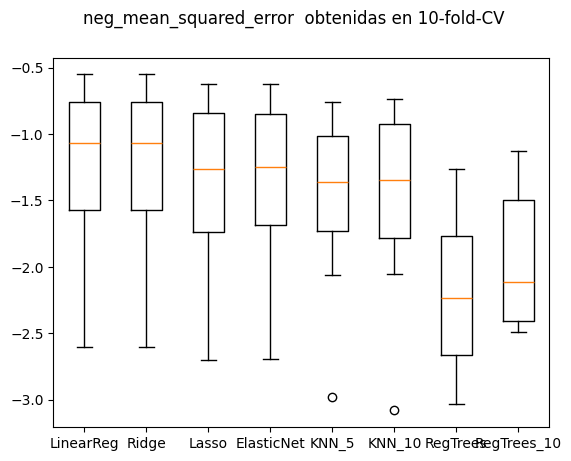

In [288]:
fig = plt.figure()
fig.suptitle('neg_mean_squared_error  obtenidas en 10-fold-CV')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

**Decisión 5:** Se decide escoger el algoritmo Ridge() para el entrenamiento del modelo. Porque presenta un valor absoluto de MSE menor que los modelos entrenados con los otros algoritmos.

In [289]:
# Reentrena modelo con todos los datos de entrenamiento y lo prueba en el conjunto de test
model = Ridge()
model.fit(x_train, y_train)
y_predicted = model.predict(x_test)

print("Mean squared error:", mean_squared_error(y_test, y_predicted))
print("Mean absolute error:", mean_absolute_error(y_test, y_predicted))
print("Explained variance score:",explained_variance_score(y_test, y_predicted) )
print("R2 score:", r2_score(y_test, y_predicted))

Mean squared error: 2.5135501831134937
Mean absolute error: 0.835163494177537
Explained variance score: 0.04775715473991837
R2 score: 0.044949033966899976


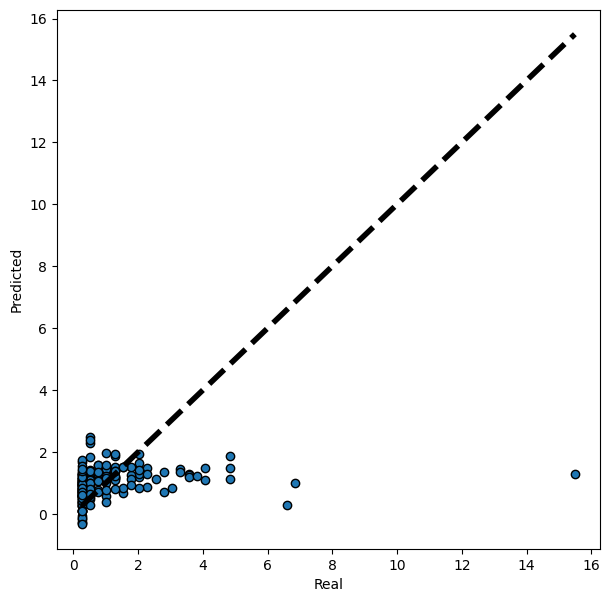

In [290]:
fig, ax = plt.subplots( figsize=[7,7])
ax.scatter(y_test, y_predicted, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Real')
ax.set_ylabel('Predicted')
plt.show()

##Se procede a entrenar el modelo pero ahora haciendo uso de Pipelines
Esto con el fin de probar si así se obtienen mejores resultados usando escaladores

In [291]:
# Definimos el pool de pipleines de ML (escalador + algoritmo de ML) a evaluar
pipelines = []

pipelines.append(('LinearReg', make_pipeline(Normalizer(), LinearRegression())))
pipelines.append(('Ridge', make_pipeline(StandardScaler(), Ridge())))
pipelines.append(('Lasso', make_pipeline(StandardScaler(), Lasso())))
pipelines.append(('ElasticNet', make_pipeline(Normalizer(), ElasticNet())))
pipelines.append(('KNN_5', make_pipeline(MinMaxScaler(), KNeighborsRegressor(n_neighbors=5))))
pipelines.append(('KNN_10', make_pipeline(MinMaxScaler(), KNeighborsRegressor(n_neighbors=10))))
pipelines.append(('RegTrees', make_pipeline(RobustScaler(), DecisionTreeRegressor())))
pipelines.append(('RegTrees_10', make_pipeline(RobustScaler(), DecisionTreeRegressor(max_depth=10))))

In [292]:
# Evaluamos cada algoritmo de ML en estrategia de 10-fold-CV
results = []
names = []

# genera el particionamiento de 10 folds que seran usados en cada evaluacion
seed = 55
kfold = KFold(n_splits=10, random_state=seed, shuffle= True)  # especifica el particionador de datos a 10-folds CV

## Evalua cada algoritmo
for pipelinename, pipeline in pipelines:
    cv_results = cross_val_score(pipeline, x_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
    results.append(cv_results)
    names.append(pipelinename)
    print("{}: {} ({})".format(pipelinename, cv_results.mean(), cv_results.std()))

LinearReg: -1.2653610063964131 (0.4105902317056793)
Ridge: -1.2719382435364657 (0.40573421763031137)
Lasso: -1.4625879138970486 (0.47898785769316055)
ElasticNet: -1.4625879138970486 (0.47898785769316055)
KNN_5: -1.4916779356256726 (0.3745149252590629)
KNN_10: -1.335235130900207 (0.40257383905999)
RegTrees: -2.0793025935403726 (0.6096299628497379)
RegTrees_10: -2.111672222818317 (0.5753219094688699)


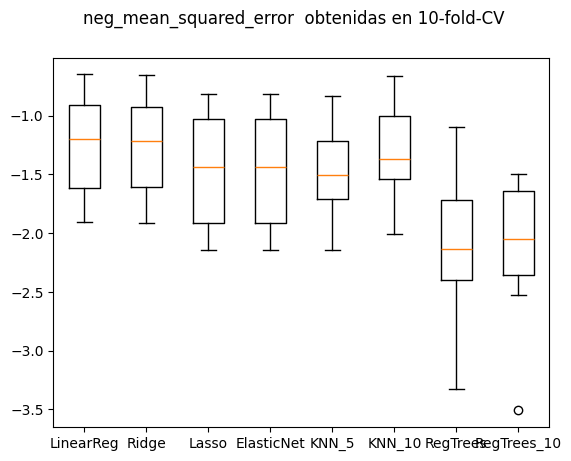

In [293]:
fig = plt.figure()
fig.suptitle('neg_mean_squared_error  obtenidas en 10-fold-CV')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

**Decisión 6:** Se decide usar el algoritmo de Ridge() con el escalador StandarScaler() porque a pesar de ser los segundos que dan menor valor absoluto de MSE, también poseen menos desviación estándar, es decir son un poco más confiables.

In [294]:
# Reentrena modelo con todos los datos de entrenamiento y lo prueba en el conjunto de test
pipeline = make_pipeline(StandardScaler(), Ridge())
pipeline.fit(x_train, y_train)

y_predicted = pipeline.predict(x_test)

print("Mean squared error:", mean_squared_error(y_test, y_predicted))
print("Mean absolute error:", mean_absolute_error(y_test, y_predicted))
print("Explained variance score:",explained_variance_score(y_test, y_predicted) )
print("R2 score:", r2_score(y_test, y_predicted))

Mean squared error: 2.5132581260602285
Mean absolute error: 0.8347806931404744
Explained variance score: 0.04789289611638847
R2 score: 0.045060004248190455


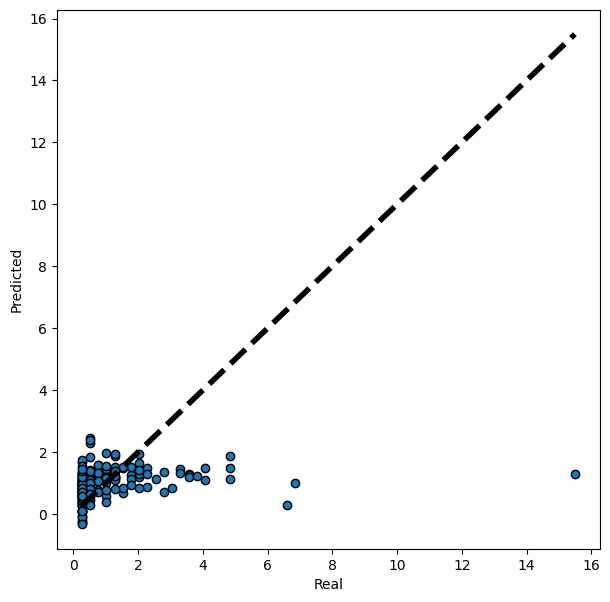

In [295]:
fig, ax = plt.subplots(figsize=[7,7])
ax.scatter(y_test, y_predicted, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Real')
ax.set_ylabel('Predicted')
plt.show()

##Se procede a entrenar el modelo de clasificación que decidirá si llueve o no
El propósito de esto es que en caso llueva, estos datos pasen al modelo de regresión lineal para predecir la cantidad exacta de profundidad sobre el suelo que causará la precipitación.

In [296]:
df_cl['rain_exists'] = df_cl['RR'].apply(lambda x: 0 if x <= 0.0 else 1)
df_cl.drop(columns='RR', inplace=True)
#extrae la variable target
X = df_cl.drop(['rain_exists'], axis=1)  # extrae las variables de entrada (sin target)
y = df_cl['rain_exists']

#Realizar la división de los datos en subconjuntos
test_size = 0.20
seed = 55   # semilla para el generador aleatorio (para reproductibilidad)
x_train,x_test,y_train,y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

# Impresión el tamaño del dataset de entrenamiento y de prueba
print("Tamaño del conjunto de entrenamiento:", len(y_train))
print("Tamaño del conjunto de prueba:", len(y_test))

Tamaño del conjunto de entrenamiento: 11572
Tamaño del conjunto de prueba: 2893


In [297]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis  # para modelos discriminantes lineales
from sklearn.naive_bayes import GaussianNB   # para modelos Naive Bayes
from sklearn.linear_model import LogisticRegression # para usar modelos de regresion logistica
from sklearn.tree import DecisionTreeClassifier     # para usar modelos de tipo arboles de decision
from sklearn.neighbors import KNeighborsClassifier  # para modelos  Knn
from sklearn.svm import SVC   # para modelos SVM

algos = []
algos.append(('LogReg', LogisticRegression( solver='liblinear', class_weight='balanced')))  #genera logistic regresors con solver liblinear
algos.append(('5NN', KNeighborsClassifier( n_neighbors=5))) #genera knn con 5 vecinos
algos.append(('10NN', KNeighborsClassifier( n_neighbors=10))) #genera knn con 5 vecinos
algos.append(('CART_none', DecisionTreeClassifier(max_depth=None ,class_weight='balanced'))) # genera DT sin restriccion de profundidad
algos.append(('CART_20', DecisionTreeClassifier(max_depth=20,class_weight='balanced'))) # genera DT sin restriccion de profundidad
algos.append(('SVM', SVC( ))) #genera SVMs con kernel radial (por default)

In [298]:
results = []
names = []

# genera el particionamiento de 10 folds que seran usados en cada evaluacion
seed = 7
kfold = KFold(n_splits=10, random_state=seed, shuffle= True)  # especifica el particionador de datos a 10-folds CV

#  evalua cada algoritmo de ML
for algoname, algo in algos:
    cv_results = cross_val_score(algo, x_train, y_train, cv=kfold, scoring='balanced_accuracy')
    results.append(cv_results)
    names.append(algoname)
    print("{}: {} ({})".format(algoname, cv_results.mean(), cv_results.std()))

LogReg: 0.8468197117398395 (0.026013483702294414)
5NN: 0.6469594517149249 (0.021712308318961874)
10NN: 0.6197570673701871 (0.021344859726882163)
CART_none: 0.6998618435338655 (0.032865394881272304)
CART_20: 0.717828732510752 (0.03762546505550857)
SVM: 0.5 (0.0)


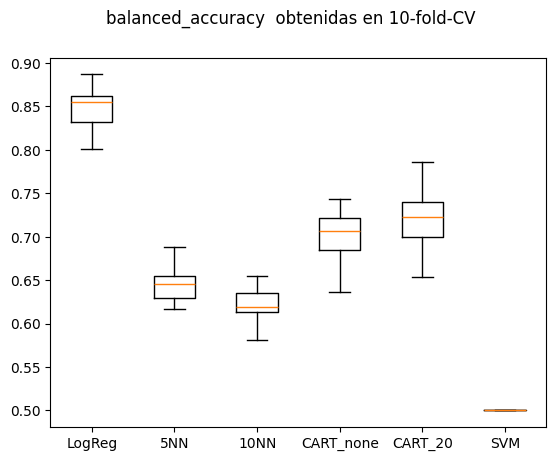

In [299]:
fig = plt.figure()
fig.suptitle('balanced_accuracy  obtenidas en 10-fold-CV')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

##Se procede a mostrar los resultados obtenidos
Tanto con el algoritmo de LogisticRegression y DecisionTreeClassifierc con 20 nodos de profundidad.

In [300]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score   # para manejar metricas de desempeño
from sklearn.metrics import classification_report  # para hacer reportes de resultados de clasificacion
from sklearn.metrics import confusion_matrix  # para manejar matrices de confusion
from sklearn.metrics import jaccard_score  # indice jacard

model = LogisticRegression(solver='liblinear' , class_weight = 'balanced') #  usar class_weight = 'balanced') para entrenar tomando en cuenta el desbalance
model.fit(x_train, y_train)

# predice la clase del conjunto de validacion
y_predicted = model.predict(x_test)
print("Balanced Accuracy score:", balanced_accuracy_score(y_test, y_predicted))

# muestra la matriz de confusion
# en la matriz de confusion, un elemento Cij es el numero de ejemplos predichos como clase j que son realmente de clase i
print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, y_predicted))

# muestra un reporte de la clasificacion en validacion
print("\nReporte de clasificacion en conjunto de validacion: \n")
print(classification_report(y_test, y_predicted))

Balanced Accuracy score: 0.840059656590002

Matriz de Confusión:
[[2167  554]
 [  20  152]]

Reporte de clasificacion en conjunto de validacion: 

              precision    recall  f1-score   support

           0       0.99      0.80      0.88      2721
           1       0.22      0.88      0.35       172

    accuracy                           0.80      2893
   macro avg       0.60      0.84      0.61      2893
weighted avg       0.94      0.80      0.85      2893



Se observa que la precisión para predecir cuando llueve es baja, pero el recall es alto, lo cuál es bueno y cumple con el propósito del proyecto.

In [301]:
model = DecisionTreeClassifier(max_depth=20,class_weight='balanced') #  usar class_weight = 'balanced') para entrenar tomando en cuenta el desbalance
model.fit(x_train, y_train)

# predice la clase del conjunto de validacion
y_predicted = model.predict(x_test)
print("Balanced Accuracy score:", balanced_accuracy_score(y_test, y_predicted))

# muestra la matriz de confusion
# en la matriz de confusion, un elemento Cij es el numero de ejemplos predichos como clase j que son realmente de clase i
print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, y_predicted))

# muestra un reporte de la clasificacion en validacion
print("\nReporte de clasificacion en conjunto de validacion: \n")
print(classification_report(y_test, y_predicted))

Balanced Accuracy score: 0.7367033323931865

Matriz de Confusión:
[[2617  104]
 [  84   88]]

Reporte de clasificacion en conjunto de validacion: 

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      2721
           1       0.46      0.51      0.48       172

    accuracy                           0.94      2893
   macro avg       0.71      0.74      0.72      2893
weighted avg       0.94      0.94      0.94      2893



El algoritmo DecisionTreeClassifier presenta una mayor precisión para predecir cuando llueve, pero su recall tiene casi 50%. Lo cuál no es tan beneficioso

In [302]:
df_final['rain_exists'] = df_final['RR'].apply(lambda x: 0 if x <= 0.0 else 1)
df_final['logRR'] = np.log1p(df_final['RR'])

# 2. Variables predictoras y targets para clasificación
X = df_final.drop(columns=['RR', 'rain_exists','logRR'])
y_cl = df_final['rain_exists']
y_reg = df_final['logRR']

# 3. Dividir el dataset (clasificación)
X_train, X_test, y_cl_train, y_cl_test, y_reg_train, y_reg_test = train_test_split(
    X, y_cl, y_reg, test_size=0.30, random_state=42
)

# 4. Entrenar el modelo de clasificación
clf = LogisticRegression(solver='liblinear' , class_weight = 'balanced')
clf.fit(X_train, y_cl_train)

# 5. Predecir en el test
y_cl_pred = clf.predict(X_test)

# 6. Evaluar clasificación
print("Clasificación:")
print("Balanced Accuracy:", balanced_accuracy_score(y_cl_test, y_cl_pred))

# 7. Filtrar solo casos donde se predijo que hay lluvia
X_reg_test = X_test[y_cl_pred == 1]
y_reg_test_true = y_reg_test[y_cl_pred == 1]

# Nota: usamos y_reg_train_full donde hay lluvia real para entrenar regresor
X_reg_train = X_train[y_cl_train == 1]
y_reg_train = y_reg_train[y_cl_train == 1]

# Impresión el tamaño del dataset de entrenamiento y de prueba
print("Tamaño del conjunto de entrenamiento:", len(X_reg_train))
print("Tamaño del conjunto de prueba:", len(X_reg_test))

# 8. Entrenar modelo de regresión solo con datos donde hay lluvia real
reg = make_pipeline(StandardScaler(), Ridge())
reg.fit(X_reg_train, y_reg_train)

# 9. Predecir cantidad de lluvia solo en predicciones positivas
if not X_reg_test.empty:

    y_reg_pred = reg.predict(X_reg_test)
    y_reg_pred = np.expm1(y_reg_pred)
    y_reg_test_true = np.expm1(y_reg_test_true)
    # 10. Evaluar regresión
    print("\nRegresión (solo en casos con lluvia predicha):")
    print("MAE:", mean_absolute_error(y_reg_test_true, y_reg_pred))
    print("MSE:", mean_squared_error(y_reg_test_true, y_reg_pred))
    print("R²:", r2_score(y_reg_test_true, y_reg_pred))
else:
    print("\nNo se predijeron casos con lluvia en el test set.")

Clasificación:
Balanced Accuracy: 0.8392152797574313
Tamaño del conjunto de entrenamiento: 629
Tamaño del conjunto de prueba: 1001

Regresión (solo en casos con lluvia predicha):
MAE: 0.63156402694406
MSE: 0.6109072684006188
R²: -0.3908338396469586


Los resultados obtenidos no son los esperados, porque su recall del algoritmo LogisticRegression era el más alto cuando predecía 1, entonces se esperaba que al unir el modelo de clasificación LogisticRegression con el modelo de regresión lineal Ridge con un StandarScaler se pueda obtener un mayor porcentaje de representación de datos, pero en este caso salió inclusive negativo. Lo que significa que el modelo es muy malo, es preferible usar la media como predicción que este modelo, por eso se decide descartarlo y usar el segundo mejor algoritmo.

In [303]:
df_final['rain_exists'] = df_final['RR'].apply(lambda x: 0 if x <= 0.0 else 1)
df_final['logRR'] = np.log1p(df_final['RR'])

# 2. Variables predictoras y targets para clasificación
X = df_final.drop(columns=['RR', 'rain_exists','logRR'])
y_cl = df_final['rain_exists']
y_reg = df_final['logRR']

# 3. Dividir el dataset (clasificación)
X_train, X_test, y_cl_train, y_cl_test, y_reg_train, y_reg_test = train_test_split(
    X, y_cl, y_reg, test_size=0.30, random_state=42
)

# 4. Entrenar el modelo de clasificación
clf = DecisionTreeClassifier(max_depth=20,class_weight='balanced')
clf.fit(X_train, y_cl_train)

# 5. Predecir en el test
y_cl_pred = clf.predict(X_test)

# 6. Evaluar clasificación
print("Clasificación:")
print("Balanced Accuracy:", balanced_accuracy_score(y_cl_test, y_cl_pred))

# 7. Filtrar solo casos donde se predijo que hay lluvia
X_reg_test = X_test[y_cl_pred == 1]
y_reg_test_true = y_reg_test[y_cl_pred == 1]

# Nota: usamos y_reg_train_full donde hay lluvia real para entrenar regresor
X_reg_train = X_train[y_cl_train == 1]
y_reg_train = y_reg_train[y_cl_train == 1]

# Impresión el tamaño del dataset de entrenamiento y de prueba
print("Tamaño del conjunto de entrenamiento:", len(X_reg_train))
print("Tamaño del conjunto de prueba:", len(X_reg_test))

# 8. Entrenar modelo de regresión solo con datos donde hay lluvia real
reg = make_pipeline(StandardScaler(), Ridge())
reg.fit(X_reg_train, y_reg_train)

# 9. Predecir cantidad de lluvia solo en predicciones positivas
if not X_reg_test.empty:

    y_reg_pred = reg.predict(X_reg_test)
    y_reg_pred = np.expm1(y_reg_pred)
    y_reg_test_true = np.expm1(y_reg_test_true)
    # 10. Evaluar regresión
    print("\nRegresión (solo en casos con lluvia predicha):")
    print("MAE:", mean_absolute_error(y_reg_test_true, y_reg_pred))
    print("MSE:", mean_squared_error(y_reg_test_true, y_reg_pred))
    print("R²:", r2_score(y_reg_test_true, y_reg_pred))
else:
    print("\nNo se predijeron casos con lluvia en el test set.")

Clasificación:
Balanced Accuracy: 0.7106564386969705
Tamaño del conjunto de entrenamiento: 629
Tamaño del conjunto de prueba: 302

Regresión (solo en casos con lluvia predicha):
MAE: 0.6901017948184383
MSE: 1.0059061436747083
R²: 0.05389288277187665


**Decisión 7:** Se decide usar el algoritmo DecisionTreeClassifier con 20 nodos de profundidad porque este provee una mejor representación de datos y las medidas de errores también son bajas.

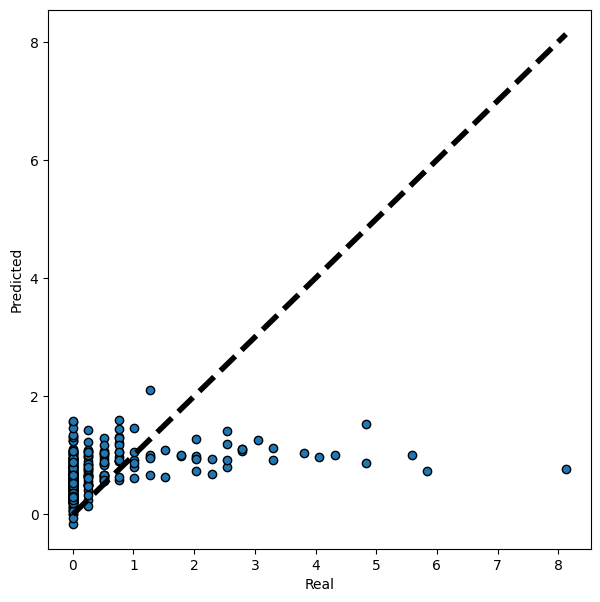

In [304]:
fig, ax = plt.subplots(figsize=[7,7])
ax.scatter(y_reg_test_true, y_reg_pred, edgecolors=(0, 0, 0))
ax.plot([y_reg_test_true.min(), y_reg_test_true.max()], [y_reg_test_true.min(), y_reg_test_true.max()], 'k--', lw=4)
ax.set_xlabel('Real')
ax.set_ylabel('Predicted')
plt.show()
